<a href="https://colab.research.google.com/github/escudero/CPUTimerPython/blob/master/clustering/chameleon/chameleon-features-filmes-bool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install wget==3.2

In [0]:
import os
import wget
import zipfile
import shutil

# Instalando METIS

In [3]:
!sudo apt-get install libmetis-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmetis5
The following NEW packages will be installed:
  libmetis-dev libmetis5
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 175 kB of archives.
After this operation, 494 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmetis5 amd64 5.1.0.dfsg-5 [169 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmetis-dev amd64 5.1.0.dfsg-5 [5,794 B]
Fetched 175 kB in 0s (1,369 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling

# Iniciando o código

In [4]:
!pip install metis
!pip install -U networkx==2.3

  Created wheel for metis: filename=metis-0.2a4-cp36-none-any.whl size=11271 sha256=5e2067f83f4c1e13d7261bb301d1e5cb096241e02a419ce33cb095ed1101da3a
  Stored in directory: /root/.cache/pip/wheels/e9/2f/3c/abdab89e7bb4008082c5035a117708e448d41ac69a83bdb2a3
Successfully built metis
     |████████████████████████████████| 1.8MB 9.5MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=be668bfb5d5b578f1d93ad00fa6b238fdbf5854faaa36379d6b9b525e08728d3
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4


In [0]:
import glob
import pandas as pd
from IPython.display import display

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import make_blobs
import networkx as nx
import metis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import time
import itertools
from tqdm import tqdm
import heapq

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
filenames = ['ml-latest.zip', 'ml-latest-small.zip']
for filename in filenames:
  wget.download('http://files.grouplens.org/datasets/movielens/{}'.format(filename))
  os.makedirs('datasets', exist_ok=True)
  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('datasets')
  os.remove(filename)

In [0]:
plotindice = 0
def plotNX(G, show_disabled=False):
  global plotindice
  plotindice += 1
  # size_clusters = max(set([v.get('cluster', 0) for v in dict(G.nodes).values()]))+1
  # colors = sns.color_palette(None, size_clusters)
  # colors = list(mcolors.CSS4_COLORS.keys())[5:]
  colors = list(mcolors.XKCD_COLORS.values())
  # colors = ['blue', 'green', 'red', 'magenta', 'purple', 'pink', 'brown', 'orange', 'teal', 'coral', 'lightblue', 'lime', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold', '#C58BE7', 'darkred', 'darkblue', 'yellow', 'cyan', 'black']
  # colors = 100 * colors

  plt.figure(figsize=(15, 6))
  # nx.draw_networkx(G, with_labels = True, node_color ='green') 
  pos = {k:v['values'][:2] for k, v in dict(G.nodes).items()}
  nodes_color = [colors[v.get('cluster', 0)] for v in dict(G.nodes).values()]
  color_disabled = '#FF0000' if show_disabled else '#FFFFFF'
  edges_color = [color_disabled if not v['enabled'] else 'grey' for v in dict(G.edges).values()]
  # nx.draw_networkx(G, pos=pos, node_size=60, linewidths=2, with_labels=False, style='dotted', alpha=0.8, edge_color=edges_color, node_color=nodes_color)
  nx.draw_networkx(G, node_size=60, linewidths=2, with_labels=False, style='dotted', alpha=0.8, edge_color=edges_color, node_color=nodes_color)
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("#000000")
  ax.collections[0].set_linewidths(0.5)
  # print(dir(ax.collections[0]))
  # plt.savefig(f'/content/drive/My Drive/imagens_puc/plot_{str(plotindice).zfill(3)}.png')
  plt.show()

def plotNXOneColor(G, show_disabled=False):
  G = G.copy()
  for n in G.nodes:
    G.nodes[n]['cluster'] = 0
  plotNX(G, show_disabled)

In [0]:
def knn_graph(df, k):
  data = df.values
  reg_count = len(data)

  distances = euclidean_distances(data, data)

  distances_sort = np.array([np.argsort(ld) for ld in distances])
  distances_sort = distances_sort[:,1:k+1]

  edges = [
    (p1, p2, {
      'weight':1.0/distances[p1, p2],
      'similarity':int(1.0/distances[p1, p2]*1e4),
      'enabled': True
    })
    for p1, sublist in enumerate(distances_sort) for p2 in sublist
  ]

  G = nx.Graph()
  G.add_nodes_from([(i, {'values': list(p), 'cluster': 0, 'userId': i+1}) for i, p in enumerate(data)])
  G.add_edges_from(edges)
  G.graph['edge_weight_attr'] = 'similarity'
  return G

In [0]:
def part_graph(graph, percent, recursive=True, verbose=False):
  count_clusters = len(graph.nodes)
  if verbose:
    print(f'Criterio de parada: {count_clusters} * {percent} = {count_clusters*percent}')
  cluster_freq = np.unique([graph.nodes.get(n).get('cluster') for n in graph.nodes], return_counts=True)
  head = []
  heapq.heapify(head)
  for p in range(len(cluster_freq[0])):
    heapq.heappush(head, (-cluster_freq[1][p], cluster_freq[0][p]))

  while len(head) > 0:
    cluster = heapq.heappop(head)[1]
    suggraph = graph.subgraph([n for n in graph.nodes if graph.nodes.get(n).get('cluster') == cluster])

    edgecuts, parts = metis.part_graph(suggraph, 2, objtype='cut', ufactor=250)

    last_cluster = max([graph.nodes.get(n).get('cluster') for n in graph.nodes])
    # parts = [p + last_cluster + 1 for p in parts]
    parts = [cluster if p == 0 else last_cluster + 1 for p in parts]

    cluster_freq = np.unique(parts, return_counts=True)
    
    if (min(cluster_freq[1]) <= (count_clusters * percent)) or len(set(parts)) == 1:
      if verbose:
        print(f'Parou em: {min(cluster_freq[1])} <= {count_clusters * percent} | ou [{len(set(parts))}]')
      continue
    else:
      if verbose:
        print(f'Não Parou em: {min(cluster_freq[1])} <= {count_clusters * percent}')
    # if recursive:
    #   plotNX(G, show_disabled=True)
    for p in range(len(cluster_freq[0])):
      heapq.heappush(head, (-cluster_freq[1][p], cluster_freq[0][p]))
    for i, p in enumerate(suggraph.nodes()):
      suggraph.node[p]['cluster'] = parts[i]
    for n1, n2 in graph.edges.keys():
      if graph.nodes[n1]['cluster'] != graph.nodes[n2]['cluster']:
        graph.edges.get((n1,n2))['enabled'] = False
      else:
        graph.edges.get((n1,n2))['enabled'] = True
    if not recursive:
      break
  return graph

In [0]:
def get_cluster(graph, clusters):
    nodes = [n for n in graph.node if graph.node[n]['cluster'] in clusters]
    return nodes

def connecting_edges(partitions, graph):
    cut_set = []
    for a in partitions[0]:
        for b in partitions[1]:
            if a in graph:
                if b in graph[a]:
                    cut_set.append((a, b))
    return cut_set

def merge_score(g, ci, cj, a):
    return relative_interconnectivity(g, ci, cj) * np.power(relative_closeness(g, ci, cj), a)

def relative_interconnectivity(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    EC = np.sum(get_weights(graph, edges))
    ECci = internal_interconnectivity(graph, cluster_i)
    ECcj = internal_interconnectivity(graph, cluster_j)
    return EC / ((ECci + ECcj) / 2.0)

def get_weights(graph, edges):
    return [graph[edge[0]][edge[1]]['weight'] for edge in edges]

def internal_interconnectivity(graph, cluster):
    return np.sum(bisection_weights(graph, cluster))

def bisection_weights(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = min_cut_bisector(cluster)
    weights = get_weights(cluster, edges)
    return weights

def min_cut_bisector(graph):
    graph = graph.copy()
    graph = part_graph(graph, 0, recursive=False)
    clusters = list(set([v.get('cluster', 0) for v in dict(graph.nodes).values()]))
    if len(clusters) < 2:
      return []
    partitions = get_cluster(graph, [clusters[0]]), get_cluster(graph, [clusters[1]])
    return connecting_edges(partitions, graph)

def relative_closeness(graph, cluster_i, cluster_j):
    edges = connecting_edges((cluster_i, cluster_j), graph)
    if not edges:
        return 0.0
    else:
        SEC = np.mean(get_weights(graph, edges))
    Ci = internal_closeness(graph, cluster_i)
    Cj = internal_closeness(graph, cluster_j)
    SECci = np.mean(bisection_weights(graph, cluster_i))
    SECcj = np.mean(bisection_weights(graph, cluster_j))
    return SEC / ((Ci / (Ci + Cj) * SECci) + (Cj / (Ci + Cj) * SECcj))

def internal_closeness(graph, cluster):
    cluster = graph.subgraph(cluster)
    edges = cluster.edges()
    weights = get_weights(cluster, edges)
    return np.sum(weights)

scores = {}

def generate_scores(graph, a, clusters, verbose):
  global scores
  l = list(itertools.combinations(clusters, 2))
  if verbose:
    l = tqdm(l)
  for combination in l:
      i, j = combination
      # print(i, j)
      if not((i, j) in scores.keys() or (j, i) in scores.keys()):
          gi = get_cluster(graph, [i])
          gj = get_cluster(graph, [j])
          edges = connecting_edges((gi, gj), graph)
          ms = np.nan
          if edges:
            # print('X')
            ms = merge_score(graph, gi, gj, a)
          scores[combination] = {
              'ci': i,
              'cj': j,
              'score': ms
          }

def merge_best(graph, a, verbose=False):
    global scores
    clusters = np.unique([graph.nodes.get(n).get('cluster') for n in graph.nodes])
    max_score = 0
    ci, cj = -1, -1

    generate_scores(graph, a, clusters, verbose)
    max_score = sorted([s for s in scores.values() if not pd.isna(s['score'])], key=lambda x: x['score'], reverse=True)[0]
    if verbose:
      print(f'max_score: {max_score}')
    
    if max_score['score'] > 0:
        ci = max_score['ci']
        cj = max_score['cj']
        for i, p in enumerate(graph.nodes()):
          if graph.node[p]['cluster'] == cj:
            graph.node[p]['cluster'] = ci
        for k in [k for k in scores.keys() if ci in k or cj in k]:
          scores.pop(k, None)
    return max_score['score'] > 0

def merge(G, min_cluster, a, verbose=False):
  global scores
  scores = {}

  t1 = time.time()
  for _ in range(100):
    cluster_count = len(np.unique([G.nodes.get(n).get('cluster') for n in G.nodes]))
    if verbose:
      print(f"Quantidade de clusters: [{cluster_count}]", flush=True)
    if cluster_count == min_cluster:
      break
    merge_best(G, a, verbose=verbose)
    # plotNX(G, show_disabled=True)

In [0]:
def chameleon(df, min_cluster=6, k=10, p=0.03, a=2, verbose=False):
  G = knn_graph(df, k)
  G = part_graph(G, p, recursive=True, verbose=verbose)
  if verbose:
    size_clusters = len(set([v.get('cluster', 0) for v in dict(G.nodes).values()]))
    print(f'Quantidade de Clusters: {size_clusters}')
  merge(G, min_cluster=min_cluster, a=a, verbose=verbose)
  return G


---------------

In [61]:
df = pd.read_csv('datasets/ml-latest-small/ratings.csv')
df.drop(columns='timestamp', errors='ignore', inplace=True)
df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [0]:
df.loc[df['rating'] >= 4, 'novo_rating'] = 1
df.loc[df['rating'] < 4, 'novo_rating'] = 0

In [63]:
df = pd.pivot_table(df, values='novo_rating', index=['userId'], columns=['movieId'], aggfunc=np.mean)
df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
df = df.fillna(0)
df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
GG = chameleon(df, min_cluster=6, k=10, p=0.03, a=2, verbose=False)
predicao = [GG.nodes[n]['cluster'] for n in GG.nodes]

In [0]:
from sklearn.manifold import TSNE

In [0]:
df['cluster'] = predicao
matrix = df.to_numpy()

In [0]:
r_tsne = TSNE(n_components=2).fit_transform(matrix)

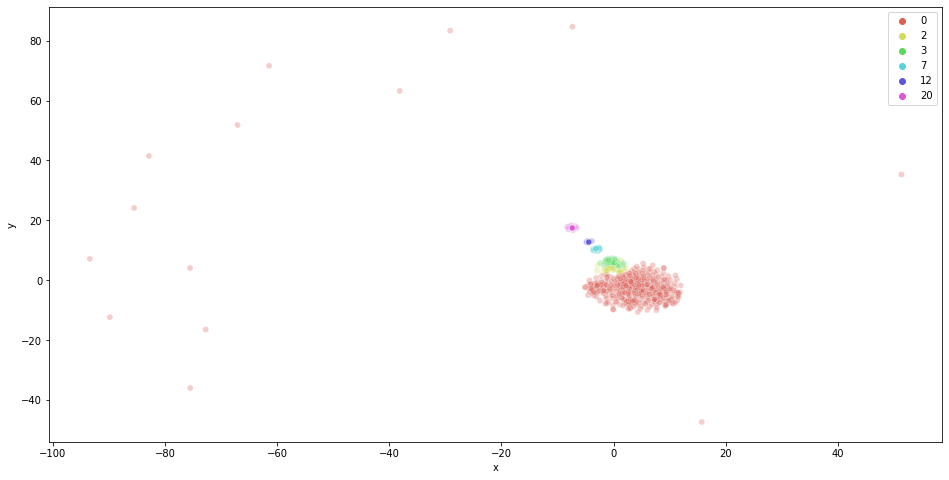

In [69]:
df_tsne = pd.DataFrame()
df_tsne['x'] = r_tsne[:,0]
df_tsne['y'] = r_tsne[:,1]
plt.figure(figsize=(16,8))
sns.scatterplot(
    x='x',
    y='y',
    hue=predicao,
    palette=sns.color_palette("hls", len(set(predicao))),
    data=df_tsne,
    legend="full",
    alpha=0.3
)
plt.legend(loc='upper right')
plt.show()